In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

class PINN_Helmholtz(nn.Module):
    def __init__(self, hidden_layers=4, hidden_units=64):
        super().__init__()
        layers = [nn.Linear(2, hidden_units), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_units, hidden_units), nn.Tanh()]
        layers.append(nn.Linear(hidden_units, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [ ]:
#helmholtz residual
def helmholtz_residual(model, x, k):
    x.requires_grad_(True)
    out = model(x)
    p_real, p_imag = out[:, 0:1], out[:, 1:2]

    grads_real = torch.autograd.grad(p_real.sum(), x, create_graph=True)[0]
    laplacian_real = torch.autograd.grad(grads_real.sum(), x, create_graph=True)[0].sum(dim=1, keepdim=True)

    grads_imag = torch.autograd.grad(p_imag.sum(), x, create_graph=True)[0]
    laplacian_imag = torch.autograd.grad(grads_imag.sum(), x, create_graph=True)[0].sum(dim=1, keepdim=True)

    residual_real = laplacian_real + k**2 * p_real
    residual_imag = laplacian_imag + k**2 * p_imag

    return (residual_real**2 + residual_imag**2).mean()


In [ ]:
Lx, Ly = 1.0, 1.0
n = 1000

interior = torch.rand(n, 2)

b = torch.linspace(0, 1, 200)
boundary_x = torch.cat([b.reshape(-1,1), torch.zeros_like(b).reshape(-1,1)], dim=1)
boundary_y = torch.cat([torch.ones_like(b).reshape(-1,1), b.reshape(-1,1)], dim=1)
boundary = torch.cat([boundary_x, boundary_y,
                      torch.cat([b.reshape(-1,1), torch.ones_like(b).reshape(-1,1)], dim=1),
                      torch.cat([torch.zeros_like(b).reshape(-1,1), b.reshape(-1,1)], dim=1)], dim=0)

def source_term(x, y, center, sigma=0.02):
    d2 = ((x - center[0])**2 + (y - center[1])**2)
    return torch.exp(-d2 / (2 * sigma**2)).reshape(-1, 1)


In [ ]:
# # Example: assign admittance based on x-position (toy case)
# def beta_function(xy_boundary):
#     beta = torch.ones_like(xy_boundary[:, 0]) * 0.01  # mostly reflective
#     beta[xy_boundary[:, 0] > 0.5] = 0.1  # less reflective material on right
#     return beta


In [ ]:
# def impedance_bc_loss(model, boundary, k, beta_fn):
#     boundary.requires_grad_(True)
#     p = model(boundary)
#     grads = torch.autograd.grad(
#         outputs=p,
#         inputs=boundary,
#         grad_outputs=torch.ones_like(p),
#         create_graph=True,
#         retain_graph=True,
#         only_inputs=True
#     )[0]

#     dp_dn = grads[:, 0] + grads[:, 1]  # Approximate normal derivative
#     beta = beta_fn(boundary)

#     # IBC: ∂p/∂n + jρωβp = 0
#     rho = 1.21
#     omega = 2 * np.pi * 300  # example: 300 Hz
#     j = torch.complex(torch.tensor(0.0), torch.tensor(1.0))

#     # Convert real output to complex (PINN returns [Re, Im])
#     p_complex = p[:, 0] + 1j * p[:, 1]

#     ibc_residual = dp_dn + j * rho * omega * beta * p_complex
#     loss_ibc = torch.mean(torch.abs(ibc_residual)**2)

#     return loss_ibc


In [ ]:

from shapely.geometry import Point, Polygon

def mask_interior_points(points, polygons):
    mask = []
    for pt in points:
        p = Point(pt[0].item(), pt[1].item())
        mask.append(not any(poly.contains(p) for poly in polygons))
    return torch.tensor(mask, dtype=torch.bool)

def sample_polygon_boundary(polygon: Polygon, num_points=100):
    exterior = polygon.exterior
    pts = [exterior.interpolate(i/num_points, normalized=True) for i in range(num_points)]
    return torch.tensor([[p.x, p.y] for p in pts], dtype=torch.float32)

def impedance_polygon_bc_loss(model, polygons_with_beta, k):
    rho   = 1.21
    omega = 2 * np.pi * 300
    j     = torch.complex(torch.tensor(0.), torch.tensor(1.))
    total = 0.0
    for poly, beta in polygons_with_beta:
        pts = sample_polygon_boundary(poly, num_points=100)
        pts.requires_grad_(True)
        p = model(pts)
        grads = torch.autograd.grad(p.sum(), pts, create_graph=True)[0]
        dp_dn = grads[:,0] + grads[:,1]                # approx ∂ₙp
        p_c   = p[:,0] + 1j*p[:,1]
        resid = dp_dn + j*rho*omega*beta * p_c
        total += torch.mean(torch.abs(resid)**2)
    return total

In [ ]:
Lx, Ly     = 1.0, 1.0
n_interior = 1000

triangle = Polygon([[0.3,0.3],[0.4,0.5],[0.2,0.5]])
rectangle = Polygon([[0.6,0.6],[0.7,0.6],[0.7,0.7],[0.6,0.7]])
polygons_with_beta = [(triangle, 0.05), (rectangle, 0.1)]
polygons = [poly for poly,_ in polygons_with_beta]

interior_all = torch.rand(n_interior, 2)
mask         = mask_interior_points(interior_all, polygons)
interior     = interior_all[mask]

b = torch.linspace(0,1,200)
boundary = torch.cat([
    torch.stack([b, torch.zeros_like(b)], dim=1),
    torch.stack([torch.ones_like(b), b], dim=1),
    torch.stack([b, torch.ones_like(b)], dim=1),
    torch.stack([torch.zeros_like(b), b], dim=1),
], dim=0)



In [ ]:

model = PINN_Helmholtz()
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

f, c = 300, 343
k    = torch.tensor(2*np.pi*f/c, dtype=torch.float32)
src_center   = torch.tensor([0,1]).reshape(1,2)
src_strength = source_term(interior[:,0], interior[:,1], src_center[0])

losses = []

for epoch in range(5000):
    opt.zero_grad()
    loss_pde       = helmholtz_residual(model, interior, k)
    loss_dirichlet = (model(boundary)**2).mean()
    loss_src       = ((model(interior) - src_strength)**2).mean()
    loss_imp       = impedance_polygon_bc_loss(model, polygons_with_beta, k)
    loss = loss_pde + loss_dirichlet + 0.01*loss_src + loss_imp
    loss.backward()
    opt.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5f}")

    if loss < 1e-5:
      print(f"Converged at {epoch}")
      break
    losses.append(loss.item())

Epoch 0: Loss = 435.87686
Epoch 500: Loss = 0.00322
Epoch 1000: Loss = 0.00199
Epoch 1500: Loss = 0.00129
Epoch 2000: Loss = 0.00080
Epoch 2500: Loss = 0.00053
Epoch 3000: Loss = 0.00031
Epoch 3500: Loss = 0.00018
Epoch 4000: Loss = 0.00011
Epoch 4500: Loss = 0.00034


Max pressure at: [0.0, 1.0], Magnitude: 0.0011
Triangle -> POLYGON ((0.3 0.3, 0.4 0.5, 0.2 0.5, 0.3 0.3))
Rectangle -> POLYGON ((0.6 0.6, 0.7 0.6, 0.7 0.7, 0.6 0.7, 0.6 0.6))


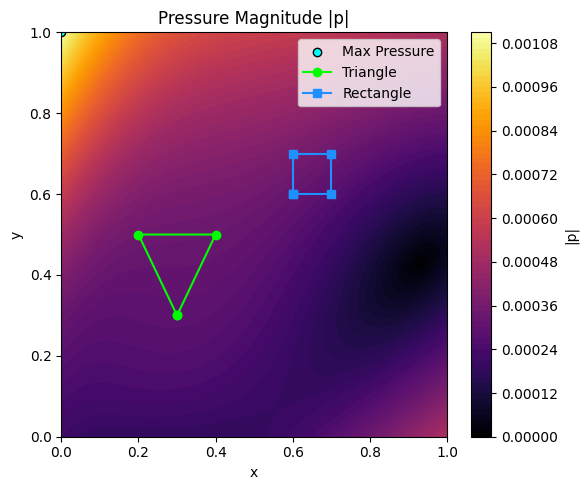

In [ ]:
nx, ny = 200, 200
x = torch.linspace(0, 1, nx)
y = torch.linspace(0, 1, ny)
X, Y = torch.meshgrid(x, y, indexing='ij')
grid = torch.stack([X.flatten(), Y.flatten()], dim=1)

with torch.no_grad():  #no training, only inference
    output = model(grid)
    p_real = output[:, 0]
    p_imag = output[:, 1]
    p_mag = torch.sqrt(p_real**2 + p_imag**2)

max_idx = torch.argmax(p_mag)
max_coord = grid[max_idx]
print(f"Max pressure at: {max_coord.tolist()}, Magnitude: {p_mag[max_idx].item():.4f}")
print("Triangle ->", triangle)
print("Rectangle ->", rectangle)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.contourf(X.numpy(), Y.numpy(), p_mag.reshape(nx, ny).numpy(), levels=100, cmap='inferno')
plt.colorbar(label='|p|')
plt.scatter(max_coord[0], max_coord[1], color='cyan', label='Max Pressure', edgecolors='black')

triangle_coords = np.array(triangle.exterior.coords)
rectangle_coords = np.array(rectangle.exterior.coords)

plt.plot(triangle_coords[:, 0], triangle_coords[:, 1], color='lime', marker='o', label='Triangle', zorder=2)
plt.plot(rectangle_coords[:, 0], rectangle_coords[:, 1], color='dodgerblue', marker='s', label='Rectangle', zorder=2)

plt.legend()
plt.title('Pressure Magnitude |p|')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


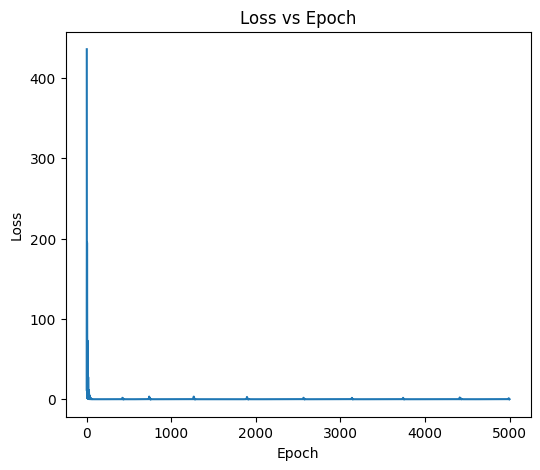

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.plot(range(5000), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

/tmp/ipython-input-1657149925.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


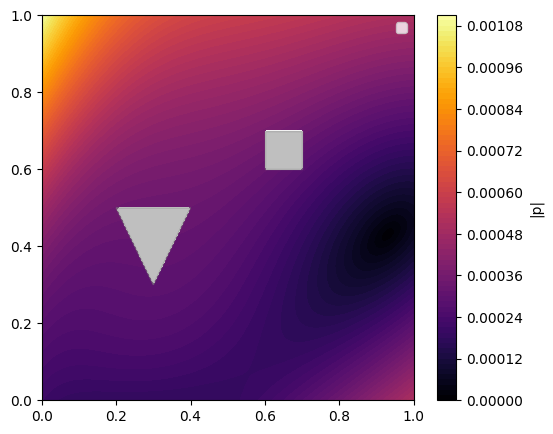

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

grid_pts = np.stack([X.flatten(), Y.flatten()], axis=1)
mask_free = np.array([not any(poly.contains(Point(x,y)) for poly in polygons)
                      for x,y in grid_pts])
p_mag_all = p_mag.numpy()

p_masked = np.ma.array(p_mag_all, mask=~mask_free)
P = p_masked.reshape(X.shape)

plt.figure(figsize=(6,5))
plt.contourf(X, Y, P, levels=100, cmap='inferno')
for poly in polygons:
    xs, ys = poly.exterior.xy
    plt.fill(xs, ys, color='gray', alpha=0.5)
plt.colorbar(label='|p|')
plt.legend()
plt.show()
